# Initial Loading of the necessary requirements

In [ ]:
%%capture
!wget https://www.dropbox.com/s/3nprin5xci4871u/Kwebbelkop.csv?dl=0
!wget https://www.dropbox.com/s/17sy1vnolq53aje/Valkyrae1.csv?dl=0
!wget https://www.dropbox.com/s/cqffu5n1aka45sv/WellAcademy1.csv?dl=0
!wget https://www.dropbox.com/s/kztegjl1w3xz0jl/TheRawKneeGames.csv?dl=0
!wget https://www.dropbox.com/s/8kl7y6ld2plx447/jellyYTData.csv?dl=0

In [ ]:
channel_name = "Valkyrae"
FEA = "title"

In [ ]:
%%capture
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

!pip install nltk
!pip install contractions

import contractions
import re

import nltk
nltk.download('all')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk import WordNetLemmatizer
nltk.download('wordnet')
lemma = WordNetLemmatizer()

import time
import random

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# Loading, Pre-processing and Applying NLP on Data

In [ ]:
loaded_data  =  pd.read_csv("Valkyrae1.csv?dl=0")
print("Number of Videos before dropping: ",loaded_data.shape[0])

loaded_data.dropna()
print("Number of Videos after dropping: ",loaded_data.shape[0])

loaded_data = loaded_data.loc[:, ~loaded_data.columns.str.contains('^Unnamed')]

loaded_data = loaded_data.drop(['release_date', 'duration','age_in_days','tags'], axis = 1)

loaded_data.head()

Number of Videos before dropping:  179
Number of Videos after dropping:  179


title   views
0               $10,000 Hide & Seek In My New Office    5470
1          Answering Your Most Asked Questions (Q&A)   33465
2                                 Don’t Move Or Die!   88302
3  I Survived 100 DAYS in a ZOMBIE APOCALYPSE! (G...  192250
4                                 STOP MOVING = DIE!  114492

In [ ]:
def apply_NLP(x):
  x = contractions.fix(x)
  x = x.lower()
  x = re.sub(r'\d+','',x)
  x = re.sub(r'[^\w\s]', '', x)
  x = word_tokenize(x)
  x = [w for w in x if not w in stopwords.words()]
  x = [ lemma.lemmatize(w, pos = "v") for w in x]
  x = [ lemma.lemmatize(w, pos = "n") for w in x]
  for i in x:
    if(len(i)==1):
      x.remove(i)
  x = ' '.join(x)
  return x

In [ ]:
loaded_data[FEA] = loaded_data[FEA].apply(apply_NLP)
print("Number of Videos: ",loaded_data.shape[0])
loaded_data.head()

Number of Videos:  179


title   views
0                   hide seek new office    5470
1                 answer ask question qa   33465
2                                   move   88302
3  survive day zombie apocalypse gta mod  192250
4                              stop move  114492

# Generate Network

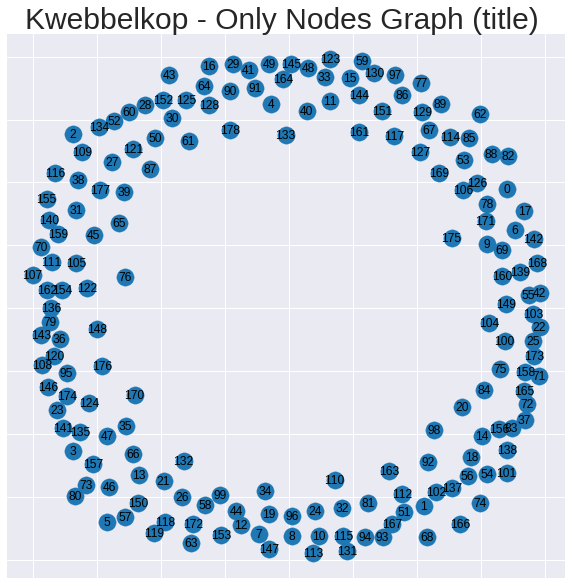

In [ ]:
G = nx.Graph()
for i in range(loaded_data.shape[0]):
  G.add_node(i,BOW=loaded_data[FEA][i],Views = loaded_data['views'][i])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, with_labels=True)
plt.title(channel_name + " - Only Nodes Graph (" + FEA+ ") ",fontsize=30)
plt.savefig(channel_name + "Nwk 1 (" + FEA + ").jpg")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


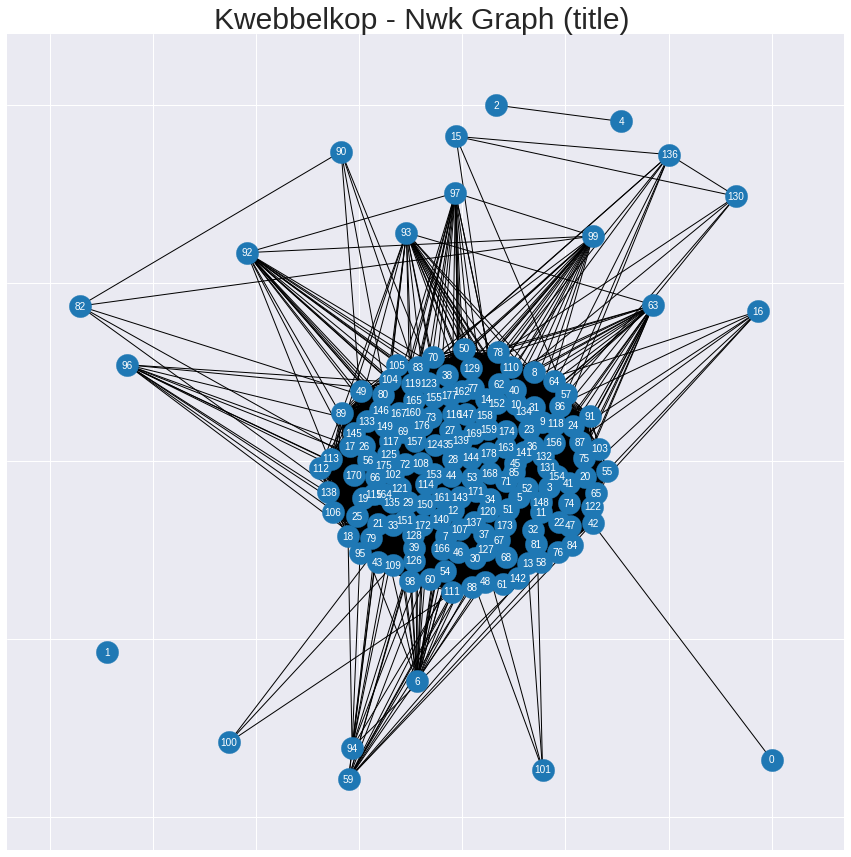

In [ ]:
def get_common(x,y):
  x = x.split(" ")
  y = y.split(" ")
  return len(list(set(x)&set(y)))

for i in range(loaded_data.shape[0]):
  for j in range(loaded_data.shape[0]):
    if(i!=j):
      t = get_common(loaded_data[FEA][i],loaded_data[FEA][j])
      if(t!=0):
        G.add_edge(i,j,weight=t)
l = ["g" for i in range(len(G.nodes))]

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, with_labels=True,node_size=500,font_size=10,font_color='W')


plt.title(channel_name + " - Nwk Graph ("+FEA+") ",fontsize=30)
plt.savefig(channel_name + "Nwk 2 ("+FEA+").jpg")
plt.show()

# Creating Matrix

In [ ]:
size = loaded_data.shape[0]
M = np.zeros((size,size))

for i in range(size):
  for j in range(size):
    t = get_common(loaded_data[FEA][i],loaded_data[FEA][j])
    M[i][j] = t

fractional_row = M[0]/np.max(M[0])
for a in range(1,np.shape(M)[0]):
  temp = M[a]/np.max(M[a])
  fractional_row = np.vstack((fractional_row,temp))

M = fractional_row
np.fill_diagonal(M,0)

print(M)

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.375 0.375]
 [0.    0.    0.    ... 0.5   0.    0.5  ]
 [0.    0.    0.    ... 0.5   0.5   0.   ]]


# Implementing Clustering Alogrithm

In [ ]:
colors = ["green","yellow","cyan","red","orange","brown","blue","magenta","purple","olive","gray","violet","lime"]

## KMeans

Value of K:  3
Old Score :  2
New Score :  1.400049726372652

Value of K:  4
Old Score :  1.400049726372652
New Score :  1.3627702771723826

Value of K:  5
Old Score :  1.3627702771723826
New Score :  1.4611323756052772

Class  0  --  [46, 51, 52, 53, 77, 102, 110, 114, 120, 121, 124, 128, 131, 132, 133, 135, 137, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178]
Class  1  --  [18, 21, 23, 26, 27, 28, 29, 31, 33, 34, 35, 36, 38, 40, 58, 71, 72, 108, 116, 117, 118, 125, 127, 139, 140]
Class  2  --  [0, 1, 2, 4, 6, 15, 16, 59, 63, 82, 90, 92, 93, 94, 96, 97, 99, 100, 101, 130, 136]
Class  3  --  [8, 17, 20, 22, 44, 48, 49, 61, 62, 64, 65, 67, 74, 76, 80, 81, 83, 84, 86, 87, 88, 91, 95, 105, 106, 111, 112, 122, 138]
Class  4  --  [3, 5, 7, 9, 10, 11, 12, 13, 14, 19, 24, 25, 30, 32, 37, 39, 41, 42, 43, 45, 47, 50, 54, 55, 56, 57, 60, 66, 68, 69, 70, 73, 75, 78, 

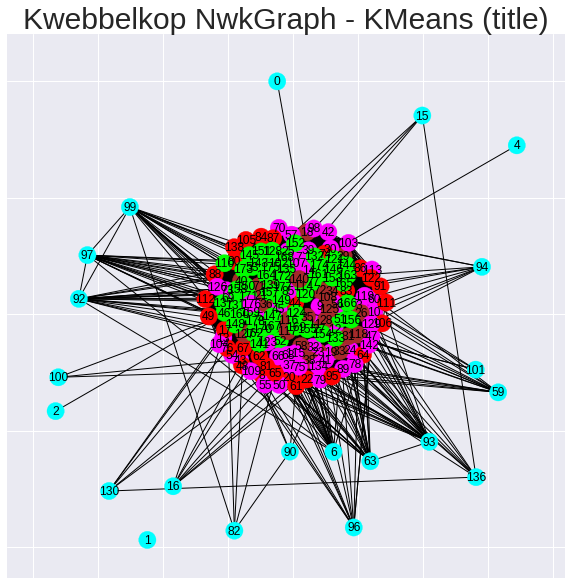

Time taken by KMeans:  0.46955108642578125  seconds.


In [ ]:
begin = time.time()
k_cluster = 2
prev_score = 2
new_score = 2
while(new_score<=prev_score):
  k_cluster+=1
  prev_score = new_score
  KM = KMeans(n_clusters = k_cluster,init='k-means++')
  KM.fit(M)
  KM_Results = KM .labels_
  new_score = davies_bouldin_score(M, KM_Results)
  print("Value of K: ",k_cluster)
  print("Old Score : ",prev_score)
  print("New Score : ",new_score)
  print()

KM_classes = [[] for i in range(k_cluster)]
for i in range(KM_Results.shape[0]):
  v = KM_Results[i]
  KM_classes[v].append(i)

for i in range(len(KM_classes)):
  print("Class ",i," -- ",KM_classes[i])

end = time.time()
time_KMeans = end-begin

choosen_colors = random.sample(colors, k_cluster)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(KM_classes)):
    if(i in KM_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - KMeans ("+FEA+")",fontsize=30)
plt.savefig(channel_name+ " NwkGraph - KMeans.jpg")
plt.show()

all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_KM = list(KM_Results)
csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_KM
KM_DF = pd.DataFrame(csv_data)
KM_DF.to_csv(channel_name + ' - KM  Final ('+FEA+').csv')
KM_DF.head()

print("Time taken by KMeans: ",time_KMeans," seconds.")

## Mean Shift

Depending on the bandwidth, the resulting clusters can look quite different. As an extreme case, imagine that we choose an extremely small bandwidth. This will result in each point having its own cluster. On the other hand, if we use a huge bandwidth, there will only be one cluster containing all the data-points

In [ ]:
BandWidth = estimate_bandwidth(M)
print("Bandwidth : ",BandWidth)

Bandwidth :  2.054219235674465


Class  0  --  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178]
Colors Choosen are:  ['blue']


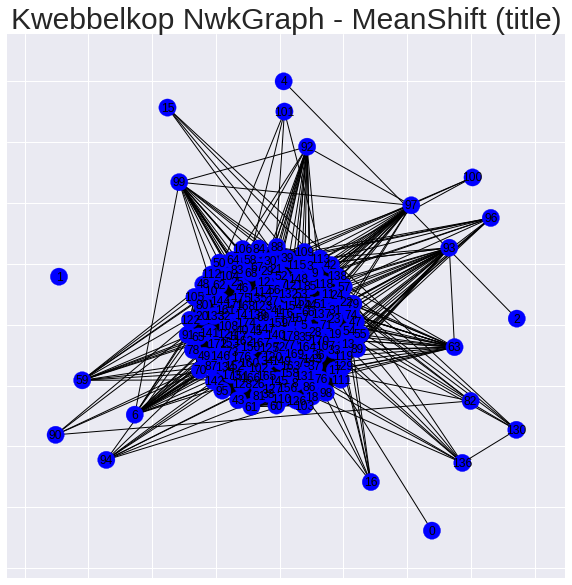

Time taken by Mean Shift:  0.9623658657073975  seconds.


In [ ]:
begin = time.time()
MS = MeanShift(bandwidth = BandWidth)
MS.fit(M)
MS_Results = MS.labels_
M_clusters = (len(np.unique(MS.labels_)))

MS_classes = [[] for i in range(M_clusters)]
for i in range(KM_Results.shape[0]):
  v = MS_Results[i]
  MS_classes[v].append(i)

for i in range(len(MS_classes)):
  print("Class ",i," -- ",MS_classes[i])

end = time.time()
time_MShift = end-begin

choosen_colors = random.sample(colors, M_clusters)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(MS_classes)):
    if(i in MS_classes[j]):
      color_map.append(choosen_colors[j])
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - MeanShift ("+FEA+")",fontsize=30)
plt.savefig(channel_name+ " NwkGraph - MeanShift ("+FEA+").jpg")
plt.show()

all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_MS = list(MS_Results)
csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_MS
KM_DF = pd.DataFrame(csv_data)
KM_DF.to_csv(channel_name + ' - MShift  Final ('+FEA+').csv')
KM_DF.head()

print("Time taken by Mean Shift: ",time_MShift," seconds.")

## DBSCAN

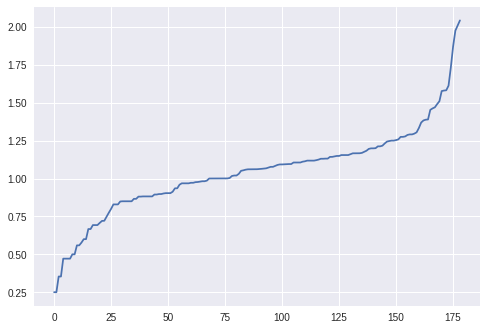

In [ ]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(M)
distances, indices = neighbors_fit.kneighbors(M)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Class  0  --  [0, 1, 2, 4, 15, 16, 90, 100, 101, 130, 136]
Class  1  --  [10, 42, 43, 47, 50, 54, 55, 57, 60, 70, 78, 79, 89, 98, 103, 104, 113, 126, 129, 142]
Class  2  --  [46, 131, 133, 137, 141, 152, 155, 156, 166]
Class  3  --  [52, 53, 102, 128, 144, 145, 148, 154, 173]
Class  4  --  [61, 91, 105, 106, 111]
Class  5  --  [21, 29, 38, 40, 118]
Class  6  --  [3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 44, 45, 48, 49, 51, 56, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86, 87, 88, 92, 93, 94, 95, 96, 97, 99, 107, 108, 109, 110, 112, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 127, 132, 134, 135, 138, 139, 140, 143, 146, 147, 149, 150, 151, 153, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178]
Colors Choosen are:  ['cyan', 'blue', 'brown', 'lime', 'olive', 'orange', 'gray']


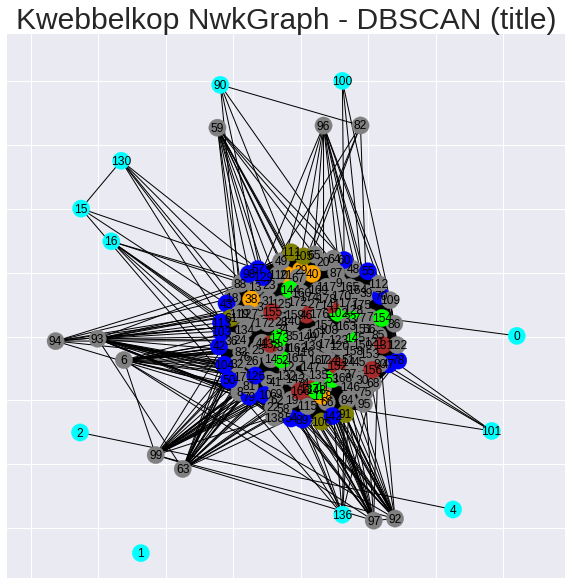

Time taken by DBSCAN:  0.01006937026977539  seconds.


In [ ]:
begin = time.time()

DBS = DBSCAN(eps=1).fit(M)
DBS_Results =  DBS.labels_
DBS_clusters = (len(np.unique(DBS.labels_)))

DBS_classes = [[] for i in range(DBS_clusters)]
for i in range(DBS_Results.shape[0]):
  v = DBS_Results[i]
  DBS_classes[v].append(i)

for i in range(len(DBS_classes)):
  print("Class ",i," -- ",DBS_classes[i])

end = time.time()
time_DBS = end-begin

choosen_colors = random.sample(colors, DBS_clusters)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(DBS_classes)):
    if(i in DBS_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - DBSCAN ("+FEA+")",fontsize=30)
plt.savefig(channel_name+ " NwkGraph - DBSCAN ("+FEA+").jpg")
plt.show()

all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_DBS = list(DBS_Results)
csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_DBS
KM_DF = pd.DataFrame(csv_data)
KM_DF.to_csv(channel_name + ' - DBSCAN  Final ('+FEA+').csv')
KM_DF.head()

print("Time taken by DBSCAN: ",time_DBS," seconds.")

## OPTICS

Class  0  --  [0, 1, 2, 4, 6, 15, 16, 82, 90, 92, 93, 94, 96, 97, 99, 100, 101, 130, 136]
Class  1  --  [42, 43, 50, 55, 70, 78, 79, 89, 98, 103]
Class  2  --  [61, 91, 95, 105, 106, 111, 112, 122]
Class  3  --  [46, 131, 133, 137, 141, 152, 155, 156, 166]
Class  4  --  [21, 23, 29, 33, 38, 40, 118]
Class  5  --  [3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 39, 41, 44, 45, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 80, 81, 83, 84, 85, 86, 87, 88, 102, 104, 107, 108, 109, 110, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 132, 134, 135, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178]
Colors Choosen are:  ['violet', 'gray', 'orange', 'red', 'olive', 'blue']


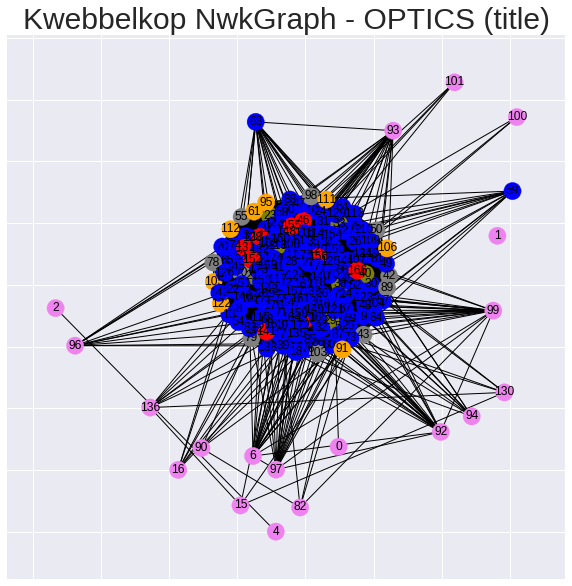

Time taken by OPTICS:  0.3428676128387451  seconds.


In [ ]:
begin = time.time()

OPT = OPTICS().fit(M)
OPT_Results =  OPT.labels_
OPT_clusters = (len(np.unique(OPT.labels_)))

OPT_classes = [[] for i in range(OPT_clusters)]
for i in range(OPT_Results.shape[0]):
  v = OPT_Results[i]
  OPT_classes[v].append(i)

for i in range(len(OPT_classes)):
  print("Class ",i," -- ",OPT_classes[i])

end = time.time()
time_OPT = end-begin

choosen_colors = random.sample(colors, OPT_clusters)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(OPT_classes)):
    if(i in OPT_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - OPTICS ("+FEA+")",fontsize=30)
plt.savefig(channel_name+ " NwkGraph - OPTICS ("+FEA+").jpg")
plt.show()

all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_OPT = list(OPT_Results)
csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_OPT
KM_DF = pd.DataFrame(csv_data)
KM_DF.to_csv(channel_name + ' - OPTICS  Final ('+FEA+').csv')
KM_DF.head()

print("Time taken by OPTICS: ",time_OPT," seconds.")

## EM using GMM

Value of K:  3
Old Score :  2
New Score :  1.3038842422561936

Value of K:  4
Old Score :  1.3038842422561936
New Score :  1.6607183893640123

Class  0  --  [0, 1, 2, 4, 6, 15, 16, 59, 63, 82, 90, 92, 93, 94, 96, 97, 99, 100, 101, 130, 136]
Class  1  --  [46, 53, 87, 102, 110, 114, 120, 121, 124, 128, 131, 132, 133, 135, 137, 141, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178]
Class  2  --  [3, 5, 7, 9, 10, 11, 12, 13, 14, 18, 19, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 42, 43, 45, 47, 50, 52, 54, 55, 56, 57, 58, 60, 66, 68, 69, 70, 72, 73, 75, 77, 78, 79, 85, 89, 98, 103, 104, 107, 108, 109, 113, 115, 117, 118, 119, 123, 125, 126, 127, 129, 134, 139, 140, 142, 148, 176]
Class  3  --  [8, 17, 20, 22, 27, 34, 41, 44, 48, 49, 51, 61, 62, 64, 65, 67, 71, 74, 76, 80, 81, 83, 84, 86, 88, 91, 95, 105, 106, 111, 112, 116, 122, 138]
Colors Choos

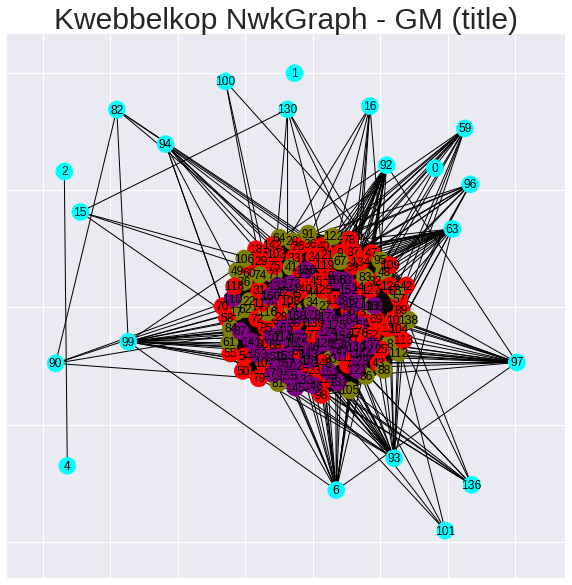

Time taken by DBSCAN:  0.22983646392822266  seconds.


In [ ]:
begin = time.time()

GM_clusters = 2
prev_score = 2
new_score = 2
while(new_score<=prev_score):
  GM_clusters+=1
  prev_score = new_score
  GM = GaussianMixture(n_components = GM_clusters)
  GM.fit(M)
  GM_Results = GM.predict(M)
  new_score = davies_bouldin_score(M, GM_Results)
  print("Value of K: ",GM_clusters)
  print("Old Score : ",prev_score)
  print("New Score : ",new_score)
  print()

GM_classes = [[] for i in range(GM_clusters)]
for i in range(GM_Results.shape[0]):
  v = GM_Results[i]
  GM_classes[v].append(i)

for i in range(len(GM_classes)):
  print("Class ",i," -- ",GM_classes[i])

end = time.time()
time_GM = end-begin

choosen_colors = random.sample(colors, GM_clusters)
print("Colors Choosen are: ", choosen_colors)
color_map = []
for i in G.nodes:
  for j in range(len(GM_classes)):
    if(i in GM_classes[j]):
      color_map.append(choosen_colors[j])
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - GM ("+FEA+")",fontsize=30)
plt.savefig(channel_name+ " NwkGraph - GM ("+FEA+").jpg")
plt.show()

all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_GM = list(GM_Results)
csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_GM
GM_DF = pd.DataFrame(csv_data)
GM_DF.to_csv(channel_name + ' - GM  Final ('+FEA+').csv')
GM_DF.head()

print("Time taken by DBSCAN: ",time_GM," seconds.")

# Final Subplot Outputs

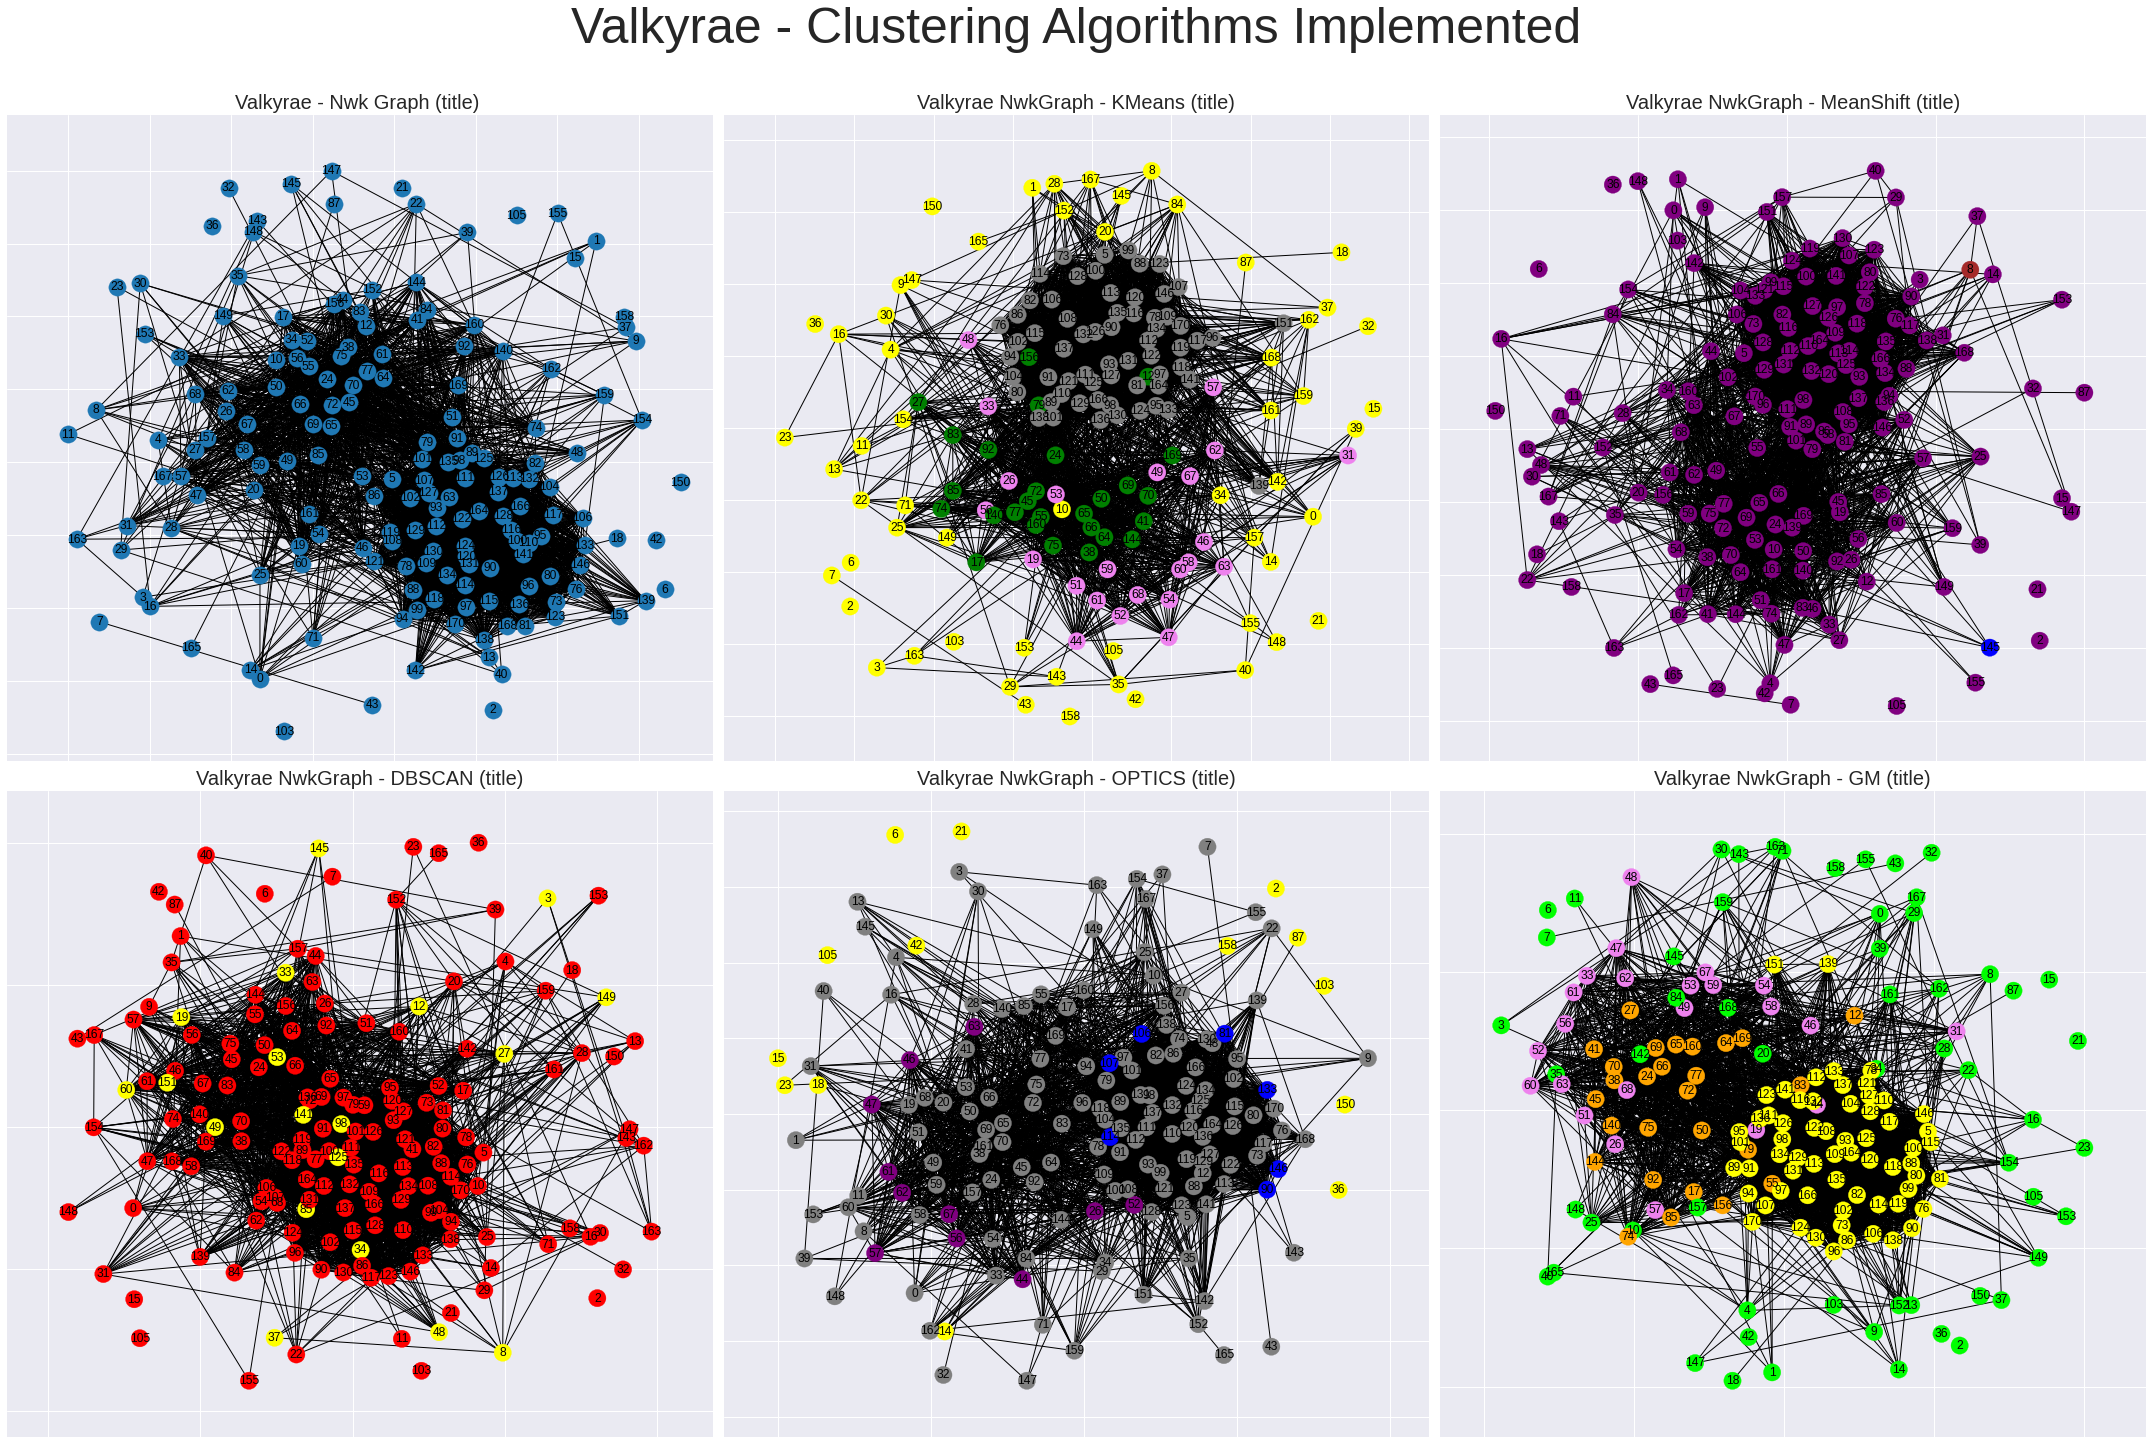

In [ ]:
plt.figure(figsize=(30,30),facecolor="w")

plt.subplot(3,3,1)
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, with_labels=True)
plt.title(channel_name + " - Nwk Graph ("+FEA+") ",fontsize=20)

plt.subplot(3,3,2)
choosen_colors = random.sample(colors, k_cluster)
color_map = []
for i in G.nodes:
  for j in range(len(KM_classes)):
    if(i in KM_classes[j]):
      color_map.append(choosen_colors[j])
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - KMeans ("+FEA+")",fontsize=20)

plt.subplot(3,3,3)
choosen_colors = random.sample(colors, M_clusters)
color_map = []
for i in G.nodes:
  for j in range(len(MS_classes)):
    if(i in MS_classes[j]):
      color_map.append(choosen_colors[j])
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - MeanShift ("+FEA+")",fontsize=20)

plt.subplot(3,3,4)
choosen_colors = random.sample(colors, DBS_clusters)
color_map = []
for i in G.nodes:
  for j in range(len(DBS_classes)):
    if(i in DBS_classes[j]):
      color_map.append(choosen_colors[j])
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - DBSCAN ("+FEA+")",fontsize=20)

plt.subplot(3,3,5)
choosen_colors = random.sample(colors, OPT_clusters)
color_map = []
for i in G.nodes:
  for j in range(len(OPT_classes)):
    if(i in OPT_classes[j]):
      color_map.append(choosen_colors[j])
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - OPTICS ("+FEA+")",fontsize=20)

plt.subplot(3,3,6)
choosen_colors = random.sample(colors, GM_clusters)
color_map = []
for i in G.nodes:
  for j in range(len(GM_classes)):
    if(i in GM_classes[j]):
      color_map.append(choosen_colors[j])
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.title(channel_name+ " NwkGraph - GM ("+FEA+")",fontsize=20)

plt.tight_layout()
plt.suptitle(channel_name+ " - Clustering Algorithms Implemented",fontsize=50)
plt.subplots_adjust(top=0.93)
plt.show()

# Computing Silhouette Score

The higher the Silhouette Coefficients (the closer to +1), the further away the cluster’s samples are from the neighbouring clusters samples. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighbouring clusters. Negative values, instead, indicate that those samples might have been assigned to the wrong cluster.

In [ ]:
if(len(KM_Results)>1):
  KM_score_1 = silhouette_score(M, KM_Results, metric='euclidean')*100
else:
  KM_score_1 = -100
print("K-Means++: ",KM_score_1)

if(M_clusters>1):
  MS_score_1 = silhouette_score(M, MS_Results, metric='euclidean')*100
else:
  MS_score_1=-100
print("Mean Shift: ",MS_score_1)

DBS_Labels = np.unique(np.array(DBS.labels_)).shape[0]
if(DBS_Labels>1):
  DBS_score_1 = silhouette_score(M, DBS_Results, metric='euclidean')*100
else:
  DBS_score_1=-100
print("DBSCAN: ",DBS_score_1)

if(len(OPT_Results)>1):
  OPT_score_1 = silhouette_score(M, OPT_Results, metric='euclidean')*100
else:
  OPT_score_1 = -100
print("OPTICS: ",OPT_score_1)

GM_Labels = np.unique(np.array(GM_Results)).shape[0]
if(GM_Labels>1):
  GM_score_1 = silhouette_score(M, GM_Results, metric='euclidean')*100
else:
  GM_score_1=-100
print("EM using GMM: ",GM_score_1)

K-Means++:  39.36798723540668
Mean Shift:  37.795830257734984
DBSCAN:  -13.497556126072752
OPTICS:  19.988235845081554
EM using GMM:  34.5868011804573


# Computing Calinski Harabasz Score

The higher the Index, the better the performance.

In [ ]:
if(len(KM_Results)>1):
  KM_score_2 = calinski_harabasz_score(M, KM_Results)
else:
  KM_score_2 = 0
print("K-Means++: ",KM_score_2)

if(M_clusters>1):
  MS_score_2 = calinski_harabasz_score(M, MS_Results)
else:
  MS_score_2=0
print("Mean Shift: ",MS_score_2)

DBS_Labels = np.unique(np.array(DBS.labels_)).shape[0]
if(DBS_Labels>1):
  DBS_score_2 = calinski_harabasz_score(M, DBS_Results)
else:
  DBS_score_2=0
print("DBSCAN: ",DBS_score_2)

if(len(OPT_Results)>1):
  OPT_score_2 = calinski_harabasz_score(M, OPT_Results)
else:
  OPT_score_2 = 0
print("OPTICS: ",OPT_score_2)

GM_Labels = np.unique(np.array(GM_Results)).shape[0]
if(GM_Labels>1):
  GM_score_2 = calinski_harabasz_score(M, GM_Results)
else:
  GM_score_2=0
print("EM using GMM: ",GM_score_2)

K-Means++:  150.09818554764317
Mean Shift:  71.34198192233687
DBSCAN:  3.1522645706370547
OPTICS:  74.48088002138488
EM using GMM:  124.41859405612846


# Analyze Clustering Algorithms

In [ ]:
Analyse_all_data = {}
Analyse_all_data["Name of Algo"] = ["K-Means ++","Mean Shift","DBSCAN","OPTICS","EM using GMM"]
Analyse_all_data["Channel Name"] = [channel_name for i in range(len(Analyse_all_data["Name of Algo"]))]
all_time_taken = []
all_time_taken.append(time_KMeans)
all_time_taken.append(time_MShift)
all_time_taken.append(time_DBS)
all_time_taken.append(time_OPT)
all_time_taken.append(time_GM)

Analyse_all_data["Time Taken"] = all_time_taken

all_no_comm = []
all_no_comm.append(k_cluster)
all_no_comm.append(M_clusters)
all_no_comm.append(DBS_clusters)
all_no_comm.append(OPT_clusters)
all_no_comm.append(GM_clusters)
Analyse_all_data["No of Communities"] = all_no_comm

all_Silhouette_Score = []
all_Silhouette_Score.append(KM_score_1)
all_Silhouette_Score.append(MS_score_1)
all_Silhouette_Score.append(DBS_score_1)
all_Silhouette_Score.append(OPT_score_1)
all_Silhouette_Score.append(GM_score_1)
Analyse_all_data["Silhouette Score"] = all_Silhouette_Score

all_calinski_harabasz_score = []
all_calinski_harabasz_score.append(KM_score_2)
all_calinski_harabasz_score.append(MS_score_2)
all_calinski_harabasz_score.append(DBS_score_2)
all_calinski_harabasz_score.append(OPT_score_2)
all_calinski_harabasz_score.append(GM_score_2)
Analyse_all_data["Calinski Harabasz Score"] = all_calinski_harabasz_score

Final_Analyse_Data = pd.DataFrame(Analyse_all_data)
Final_Analyse_Data.to_csv(channel_name + ' - Algorithm Analysis ('+FEA+').csv')
Final_Analyse_Data

Name of Algo Channel Name  Time Taken  No of Communities  Silhouette Score  \
0    K-Means ++     Valkyrae    0.339241                  4         30.250124   
1    Mean Shift     Valkyrae    0.878246                  3         11.743895   
2        DBSCAN     Valkyrae    0.006867                  2         22.478389   
3        OPTICS     Valkyrae    0.307860                  4        -21.380345   
4  EM using GMM     Valkyrae    0.169067                  4         30.250124   

   Calinski Harabasz Score  
0                69.798904  
1                 1.550127  
2                 4.961460  
3                 6.471072  
4                69.798904